# A Data Scientist’s Approach for Algorithmic Trading Using Deep Reinforcement Learning
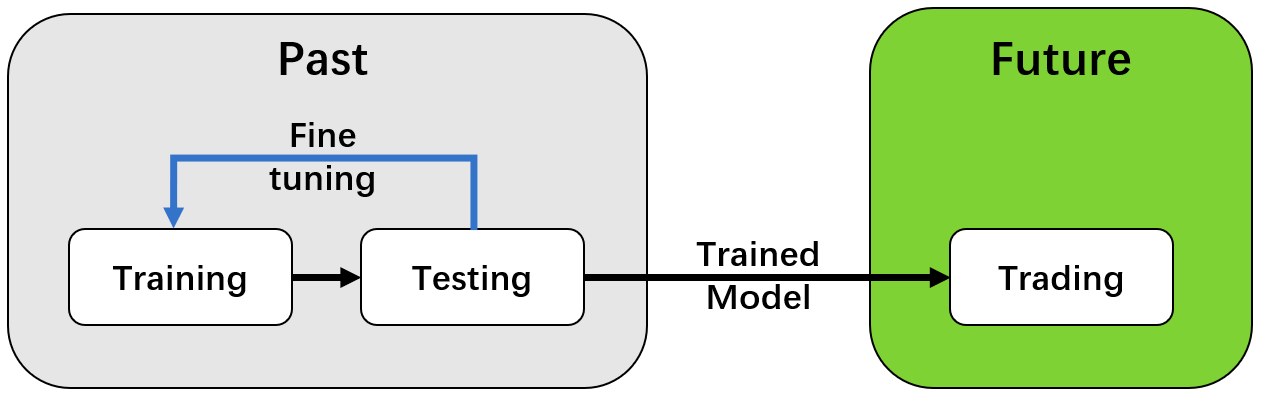

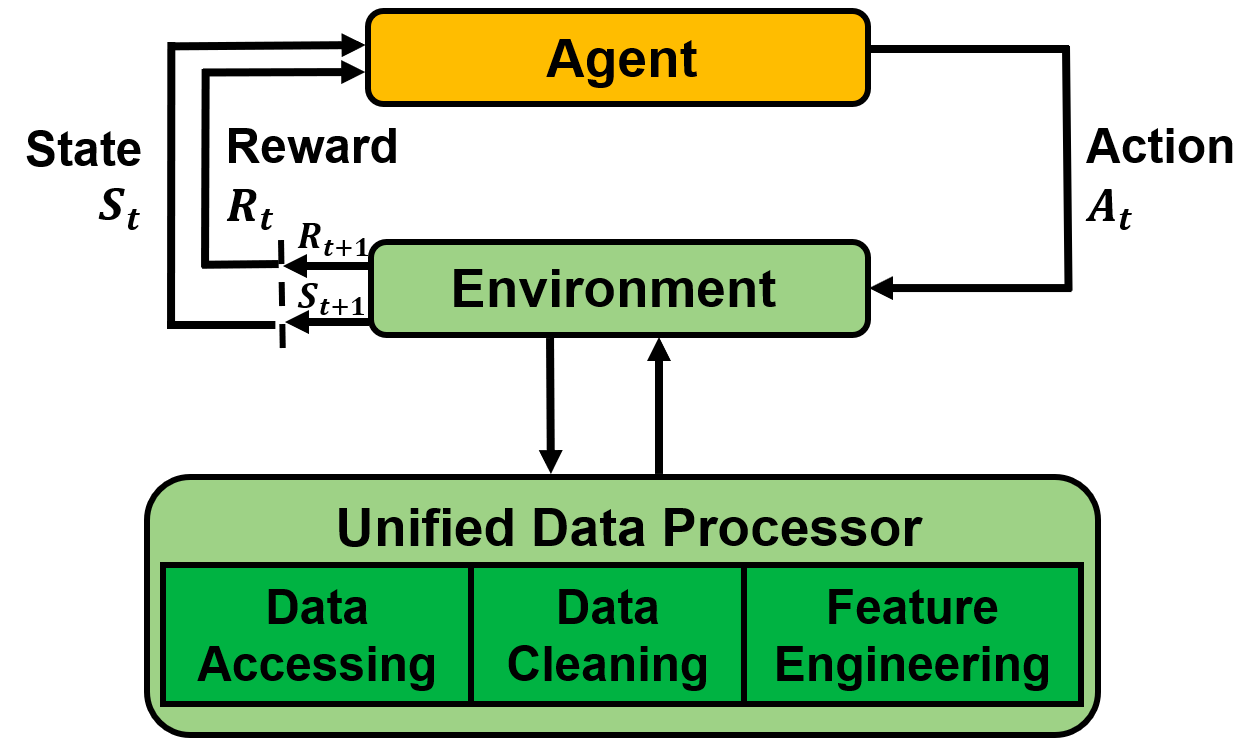

In [ ]:
!pip install yfinance pandas scikit-learn openai alpaca-trade-api

In [68]:
# !pip install yfinance pandas scikit-learn openai alpaca-trade-api matplotlib

import os
from alpaca_trade_api import REST, TimeFrame
import warnings
warnings.filterwarnings("ignore")

# Set up your Alpaca API keys
API_KEY = "AKAMB2LOIF8LP5M5FLL0"
API_SECRET = "ZLaI4bJ90xBUBTC5byde3Fa7XiAVVHbnghBP85aE"
OPENAI_API_KEY = "sk-proj-KhuQ3fUHChSOhrWloSdDT3BlbkFJ6K13Rz8cqhIXcjqy9xBW"
BASE_URL = "https://api.alpaca.markets"

os.environ["APCA_API_KEY_ID"] = API_KEY
os.environ["APCA_API_SECRET_KEY"] = API_SECRET

api = REST(API_KEY, API_SECRET, base_url=BASE_URL)

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Download historical data using yfinance
symbol = "AAPL"
data = yf.download(symbol, start="2020-01-01", end="2023-01-01")
print(data.head())




[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.876114  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.167610  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.742653  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.400528  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.565193  132079200


In [69]:

# Example: Add moving averages as features
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()
data.dropna(inplace=True)

# Define target (e.g., 1 if price goes up, 0 if it goes down)
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# Split data into features and target
X = data[['MA_10', 'MA_50']]
y = data['Target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

# Simulate trading strategy
initial_cash = 10000
cash = initial_cash
positions = 0
portfolio_value = []

for index, row in X_test.iterrows():
    if model.predict([row])[0] == 1 and cash > row['MA_50']:
        # Buy
        quantity = cash // row['MA_50']
        cash -= quantity * row['MA_50']
        positions += quantity
    elif model.predict([row])[0] == 0 and positions > 0:
        # Sell
        cash += positions * row['MA_50']
        positions = 0
    # Track portfolio value
    portfolio_value.append(cash + positions * row['MA_50'])

# Final portfolio value
final_value = cash + positions * X_test.iloc[-1]['MA_50']
print(f"Initial Cash: ${initial_cash}, Final Portfolio Value: ${final_value}")



Model Accuracy: 0.4788732394366197
Initial Cash: $10000, Final Portfolio Value: $9396.75076278687


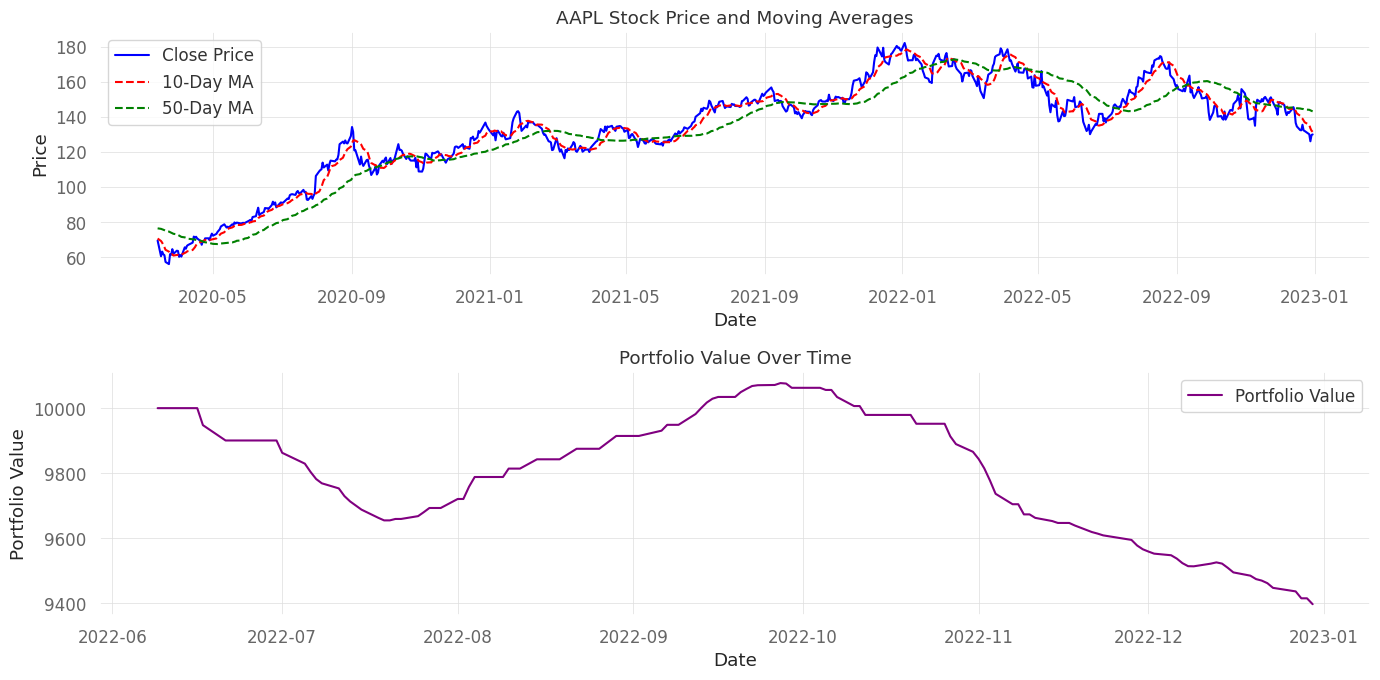

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
# Basic Check for Plotting
plt.figure(figsize=(14, 7))

# Plot stock price and moving averages
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.plot(data.index, data['MA_10'], label='10-Day MA', linestyle='--', color='red')
plt.plot(data.index, data['MA_50'], label='50-Day MA', linestyle='--', color='green')
plt.title('AAPL Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Ensure portfolio_value aligns with X_test index
plt.subplot(2, 1, 2)
plt.plot(X_test.index, portfolio_value, label='Portfolio Value', color='purple')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)

# Ensure plots are displayed
plt.tight_layout()
plt.show()